[home](http://www.brandonrose.org)

# Document Clustering with Python

<img src='header_short.jpg'>

In this guide, I will explain how to cluster a set of documents using Python. My motivating example is to identify the latent structures within the synopses of the top 100 films of all time (per an IMDB list). See [the original post](http://www.brandonrose.org/top100) for a more detailed discussion on the example. This guide covers:

<ul>
<li> tokenizing and stemming each synopsis
<li> transforming the corpus into vector space using [tf-idf](http://en.wikipedia.org/wiki/Tf%E2%80%93idf)
<li> calculating cosine distance between each document as a measure of similarity
<li> clustering the documents using the [k-means algorithm](http://en.wikipedia.org/wiki/K-means_clustering)
<li> using [multidimensional scaling](http://en.wikipedia.org/wiki/Multidimensional_scaling) to reduce dimensionality within the corpus
<li> plotting the clustering output using [matplotlib](http://matplotlib.org/) and [mpld3](http://mpld3.github.io/)
<li> conducting a hierarchical clustering on the corpus using [Ward clustering](http://en.wikipedia.org/wiki/Ward%27s_method)
<li> plotting a Ward dendrogram
<li> topic modeling using [Latent Dirichlet Allocation (LDA)](http://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)
</ul>

## Contents

<ul>
<li>[Stopwords, stemming, and tokenization](#Stopwords,-stemming,-and-tokenizing)
<li>[Tf-idf and document similarity](#Tf-idf-and-document-similarity)
<li>[K-means clustering](#K-means-clustering)
<li>[Multidimensional scaling](#Multidimensional-scaling)
<li>[Visualizing document clusters](#Visualizing-document-clusters)
<li>[Hierarchical document clustering](#Hierarchical-document-clustering)
<li>[Latent Dirichlet Allocation (LDA)](#Latent-Dirichlet-Allocation)
</ul>

But first, I import everything I am going to need up front

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import csv
import nltk
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
from scipy.stats import mstats


# Stopwords, stemming, and tokenizing

In [2]:
#import three lists: titles, links and wikipedia synopses
#import the category1, createdDate1, storyTitle3, state9 and story10 from csv
colnames = ['category', 'createdDate', 'storyTitle', 'amountRaised', 'goal', 'donors', 'campaignLength', 'likes', 'shares', 'engRate', 'sucRate', 'city', 'state', 'story']
#read in data 
# gfmData = pd.read_csv('health-insurance-984.csv')

gfmData = pd.read_csv('gfm-medical-sample-15k.csv')


#drop any row with a null value
data = gfmData.dropna(how='any')

#saved_column = df.column_name #you can also use df['column_name']
#category,createdDate,storyTitle,amountRaised,goal,donors,campaignLength,likes,shares,city,state,story



categories = data.category.tolist()
titles = data.storyTitle.tolist()
states = data.state.tolist()
stories = data.story.tolist()
dates = data.createdDate.tolist()
amounts = data.amountRaised.tolist()
goals = data.goal.tolist()
donors = data.donors.tolist()
lengths = data.campaignLength.tolist()
likes = data.likes.tolist()
shares = data.shares.tolist()
cities = data.city.tolist()
urls = data.url.tolist()
engagementRates = data.engRate.tolist()
successRates = data.sucRate.tolist()

##remove outliers from dataFrame
##https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
# df = pd.DataFrame(np.random.randn(100, 3))

# from scipy import stats
# df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]


#get dataframe summary
# print(data.head())




## Removing outliers from dataframe


In [3]:
## create dataframe with numerica values and then get 99th percentile 
## run conditional on coumns of full dataframe to be sure to drop any rows with outliers in any column

numData = { 'title': titles, 'url': urls, 'story': stories, 'cluster': clusters, 'donors': donors, 'shares': shares, 'length': lengths, 'raised': amounts, 'goal':goals, 'engagement': engagementRates, 'success': successRates, 'city': cities, 'state': states }
numFrame = pd.DataFrame(numData, columns = ['raised', 'goal', 'engagement', 'success', 'donors', 'shares'])
# numFrame = pd.DataFrame(numData, index = [clusters] , columns = ['title', 'url', 'cluster', 'city', 'state', 'story', 'raised', 'goal', 'engagement', 'success', 'donors', 'shares', 'length'])

print(numFrame.head())


NameError: name 'clusters' is not defined

In [5]:
##get ranges for 99th percentile
low = .01
high = .99
quant_df = numFrame.quantile([low, high])
print(quant_df)

NameError: name 'numFrame' is not defined

In [6]:
# ##Create new dataframe wihtout the outliers

numFrame = numFrame.apply(lambda x: x[(x > quant_df.loc[low,x.name]) & 
                                    (x < quant_df.loc[high,x.name])], axis=0)
numFrame.describe()

NameError: name 'numFrame' is not defined

In [256]:
##create dataframe to then remove outliers with high success rates and goals to normalize data
allData = { 'title': titles, 'url': urls, 'story': stories, 'cluster': clusters, 'donors': donors, 'shares': shares, 'length': lengths, 'raised': amounts, 'goal':goals, 'engagement': engagementRates, 'success': successRates, 'city': cities, 'state': states }

dfObj = pd.DataFrame(allData, index = None, columns = ['title', 'url', 'cluster', 'city', 'state', 'story', 'raised', 'goal', 'engagement', 'success', 'donors', 'shares', 'length'])

print(dfObj.describe())

           cluster         raised           goal   engagement       success  \
count  1995.000000    1995.000000    1995.000000  1995.000000  1.995000e+03   
mean      5.131328    5369.742356   18910.605514    14.704762  1.062265e+03   
std       3.166208   10199.893203   35348.375815     9.121687  4.245117e+04   
min       0.000000      75.000000       1.000000     0.000000  0.000000e+00   
25%       2.000000     907.500000    5000.000000     8.000000  1.200000e+01   
50%       6.000000    2170.000000   10000.000000    13.000000  3.100000e+01   
75%       8.000000    5489.500000   20000.000000    19.000000  6.600000e+01   
max       9.000000  156836.000000  500000.000000    57.000000  1.893300e+06   

            donors        shares       length  
count  1995.000000   1995.000000  1995.000000  
mean     54.684712    324.362907     6.237594  
std      85.806811    673.535207     1.221543  
min       1.000000      2.000000     1.000000  
25%      13.000000     77.000000     6.000000  


In [7]:
# Remove rows for which columns 'goal' or 'success' are outside the 99th percentile
# df[((df.one > 0) | (df.two > 0) | (df.three > 0)) & (df.four < 1)]
dfAll = dfObj[((dfObj['goal'] < 600) | (dfObj['goal'] > 175000)) | ((dfObj['success'] < 2) | (dfObj['success'] > 262)) ].index
# dfAll = dfObj[(dfObj['raised'] > 47376) ].index
# Delete these row indexes from dataFrame
dfObj.drop(dfAll, inplace=True)

print(dfObj.describe())
dfObj.plot()

NameError: name 'dfObj' is not defined

### Print top 10 stories and titles


In [3]:
print(stories[1][:200])
print(titles[:10])

# synopses_imdb = open('synopses_list_imdb.txt').read().split('\n BREAKS HERE')
# synopses_imdb = synopses_imdb[:100]

# synopses_clean_imdb = []

# for text in synopses_imdb:
#     text = BeautifulSoup(text, 'html.parser').getText()
#     #strips html formatting and converts to unicode
#     synopses_clean_imdb.append(text)

# synopses_imdb = synopses_clean_imdb

Please help me fund monthly air travel for a life saving brain tumor trial that requires monthly travel from Florida to NYC.  Credit cards maxed out. Please see my full story  below.  https://www.patr
['Deb and Tom Carie Heart Transplant', 'Byron&#x2019;s brain tumor trial air fare', 'A new smile for Conor', 'Jordan family', 'Healing to Cherie Giambalvo', 'Loving Father in Need', 'Support for Matthew Burchell', 'Lewallen&apos;s Medical Despair', 'Help Kara through her recovery', 'Rita Cargill Ellerd Cancer Fund']


In [4]:
# synopses = []

# for i in range(len(synopses_wiki)):
#     item = synopses_wiki[i] + synopses_imdb[i]
#     synopses.append(item)

In [4]:
# generates index for each item in the corpora (in this case it's just rank) and I'll use this for scoring later
ranks = []

for i in range(0,len(titles)):
    ranks.append(i)

This section is focused on defining some functions to manipulate the synopses. First, I load [NLTK's](http://www.nltk.org/) list of English stop words. [Stop words](http://en.wikipedia.org/wiki/Stop_words) are words like "a", "the", or "in" which don't convey significant meaning. I'm sure there are much better explanations of this out there.

In [5]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(["&#x", "'s", "'d", "n't", "medical", "Medical", "donations", "needs", "&apos;s", "&#x2019;s", "&#x201C;", "&#x201D;", 'abov', 'ani', 'apo', 'becaus', 'befor', 'could', 'doe', 'donat', 'dure', 'medic', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'x', 'x2019', 'x201c', 'x201d', 'yourselv'])

#extend stopwords
# NLTK Stop words
# from nltk.corpus import stopwords
# stop_words = stopwords.words('english')
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
print(len(stopwords))

218


Next I import the [Snowball Stemmer](http://snowball.tartarus.org/) which is actually part of NLTK. [Stemming](http://en.wikipedia.org/wiki/Stemming) is just the process of breaking a word down into its root.

In [6]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")


Below I define two functions:

<ul>
<li> *tokenize_and_stem*: tokenizes (splits the synopsis into a list of its respective words (or tokens) and also stems each token <li> *tokenize_only*: tokenizes the synopsis only
</ul>

I use both these functions to create a dictionary which becomes important in case I want to use stems for an algorithm, but later convert stems back to their full words for presentation purposes. Guess what, I do want to do that!



In [7]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

Below I use my stemming/tokenizing and tokenizing functions to iterate over the list of synopses to create two vocabularies: one stemmed and one only tokenized. 

In [8]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in stories:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

Using these two lists, I create a pandas DataFrame with the stemmed vocabulary as the index and the tokenized words as the column. The benefit of this is it provides an efficient way to look up a stem and return a full token. The downside here is that stems to tokens are one to many: the stem 'run' could be associated with 'ran', 'runs', 'running', etc. For my purposes this is fine--I'm perfectly happy returning the first token associated with the stem I need to look up.

In [10]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

## Tf-idf and document similarity

<img src='http://www.jiem.org/index.php/jiem/article/viewFile/293/252/2402' align='right' style="margin-left:10px">

Here, I define term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the *synopses* list into a tf-idf matrix. 

To get a Tf-idf matrix, first count word occurrences by document. This is transformed into a document-term matrix (dtm). This is also just called a term frequency matrix. An example of a dtm is here at right.

Then apply the term frequency-inverse document frequency weighting: words that occur frequently within a document but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the document.

A couple things to note about the parameters I define below:

<ul>
<li> max_df: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining (in the context of film synopses)
<li> min_idf: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here I pass 0.2; the term must be in at least 20% of the document. I found that if I allowed a lower min_df I ended up basing clustering on names--for example "Michael" or "Tom" are names found in several of the movies and the synopses use these names frequently, but the names carry no real meaning.
<li> ngram_range: this just means I'll look at unigrams, bigrams and trigrams. See [n-grams](http://en.wikipedia.org/wiki/N-gram)
</ul>

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer


# stop_words = set(stopwords.words('english'))
#vectorizer = TfidfVectorizer(stop_words='english')

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.99, max_features=200000,
                                 min_df=0.01, stop_words= set(stopwords),
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(stories) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

CPU times: user 15.5 s, sys: 233 ms, total: 15.7 s
Wall time: 16 s
(1995, 2131)


In [16]:
terms = tfidf_vectorizer.get_feature_names()
# print(tfidf_matrix)
print(terms)


["'m", "'m ask", "'m go", '11th', '1st', '28th', '2nd', '30th', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', 'abdomen', 'abil', 'abl', 'abl afford', 'abl get', 'abl go', 'abl help', 'abl pay', 'abl return', 'abl work', 'abnorm', 'absenc', 'absolut', 'abus', 'accept', 'access', 'accid', 'accommod', 'accomplish', 'accord', 'account', 'achiev', 'across', 'act', 'action', 'activ', 'actual', 'acut', 'ad', 'add', 'addit', 'address', 'adjust', 'administ', 'admit', 'admit hospit', 'adult', 'advanc', 'advanc help', 'advis', 'affect', 'afford', 'age', 'aggress', 'aggress form', 'ago', 'agre', 'ahead', 'aid', 'air', 'aka', 'al', 'aliv', 'allevi', 'allow', 'almost', 'almost year', 'alon', 'along', 'alreadi', 'also', 'also help', 'altern', 'although', 'alway', 'alway help', 'alway put', 'amaz', 'ambul', 'amigo', 'among', 'amount', 'amount great', 'amount help', 'amount small', 'amount time', 'amput', 'and/or', 'angel', 'anim', 'ankl', 'anoth', 'answer', 'antibiot', 'anticip', 'anxieti', 'anymor

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

# K-means clustering

Now onto the fun part. Using the tf-idf matrix, you can run a slew of clustering algorithms to better understand the hidden structure within the synopses. I first chose [k-means](http://en.wikipedia.org/wiki/K-means_clustering). K-means initializes with a pre-determined number of clusters (I chose 5). Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and  centroids recalculated in an iterative process until the algorithm reaches convergence.

I found it took several runs for the algorithm to converge a global optimum as k-means is susceptible to reaching local optima. 

In [18]:
from sklearn.cluster import KMeans

num_clusters = 10

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 54.1 s, sys: 7.4 s, total: 1min 1s
Wall time: 36.5 s


In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

In [71]:
# first attempt at fitting K means to view change in Inertia

# container to store inertia scores over iterations
distortions = []

# fit KMeans iteratively to begin to assess the appropriate number of clusters

for i in range(1, 10):
    km = KMeans(n_clusters=i)
    km.fit(tfidf_matrix)
    distortions.append(km.inertia_)
    
# vizualize change in inertia
plt.plot(range(1, 10), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

ValueError: could not convert string to float: "'m"

In [83]:
# modify this list to include the numbers of clusters you want to see
# I have *arbitrarily* chosen these values
range_n_clusters = [3, 5, 10, 15, 20, 25, 50]


For n_clusters = 3 The average silhouette_score is : 0.017994967884146826


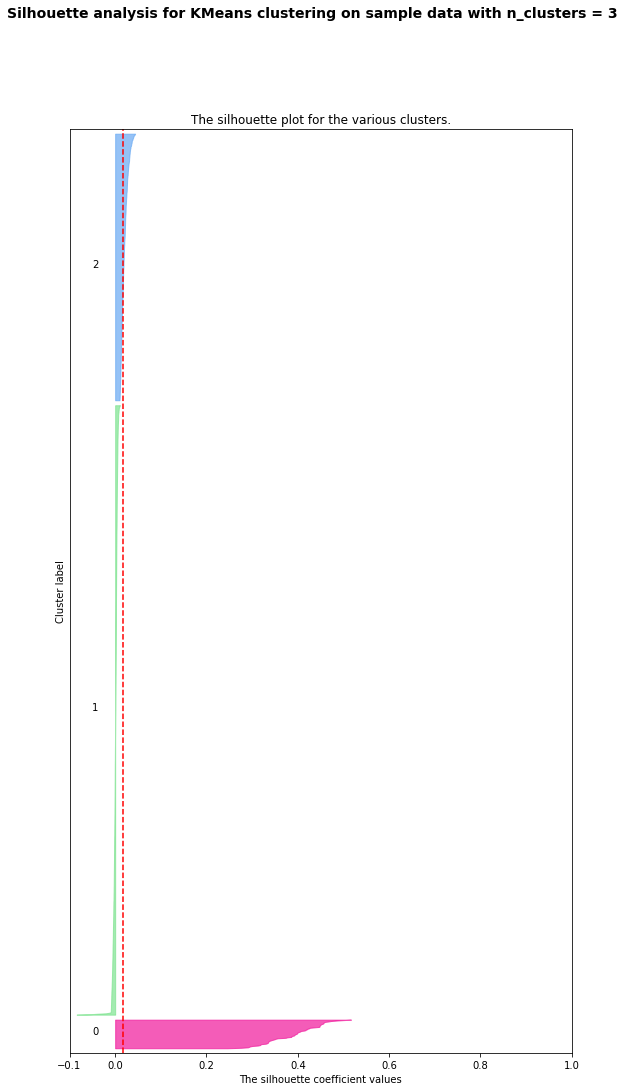

For n_clusters = 5 The average silhouette_score is : 0.01704781630374818


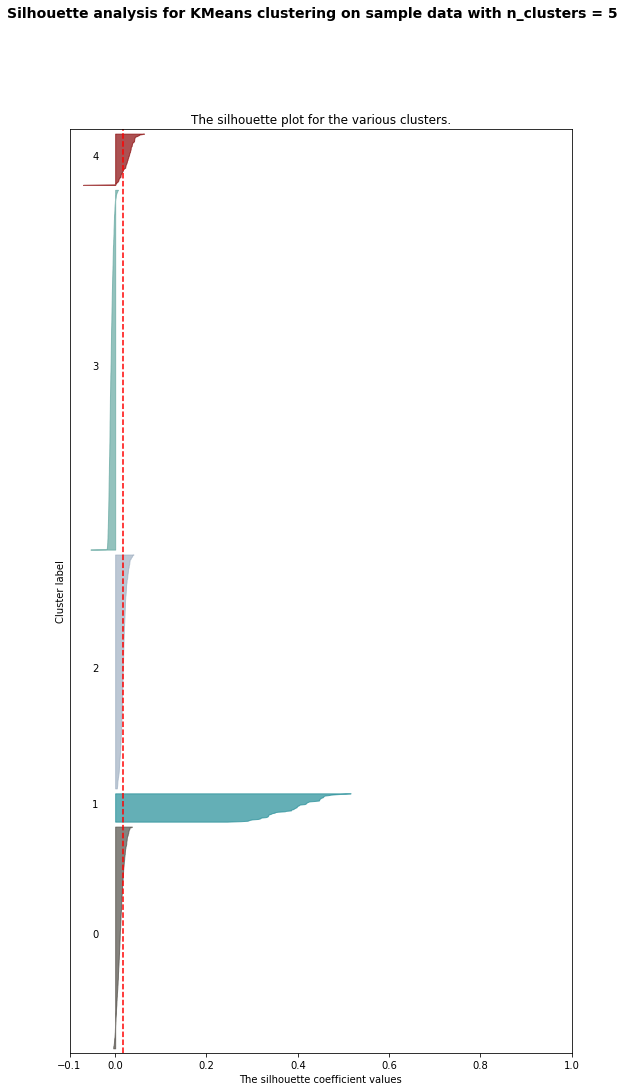

For n_clusters = 10 The average silhouette_score is : 0.018402002598037277


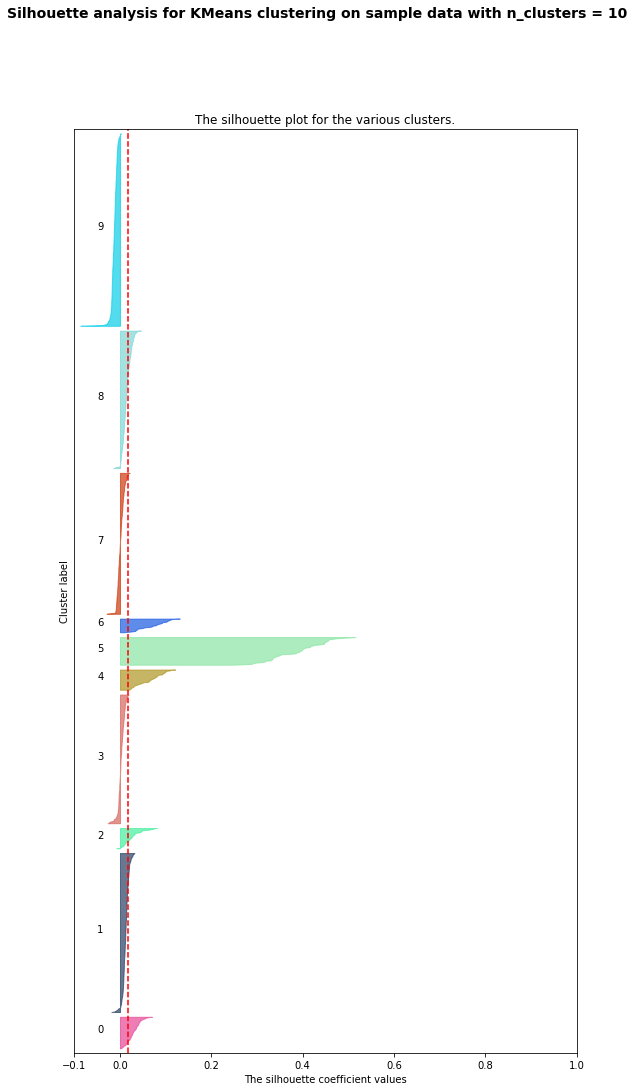

For n_clusters = 15 The average silhouette_score is : 0.01152195951471833


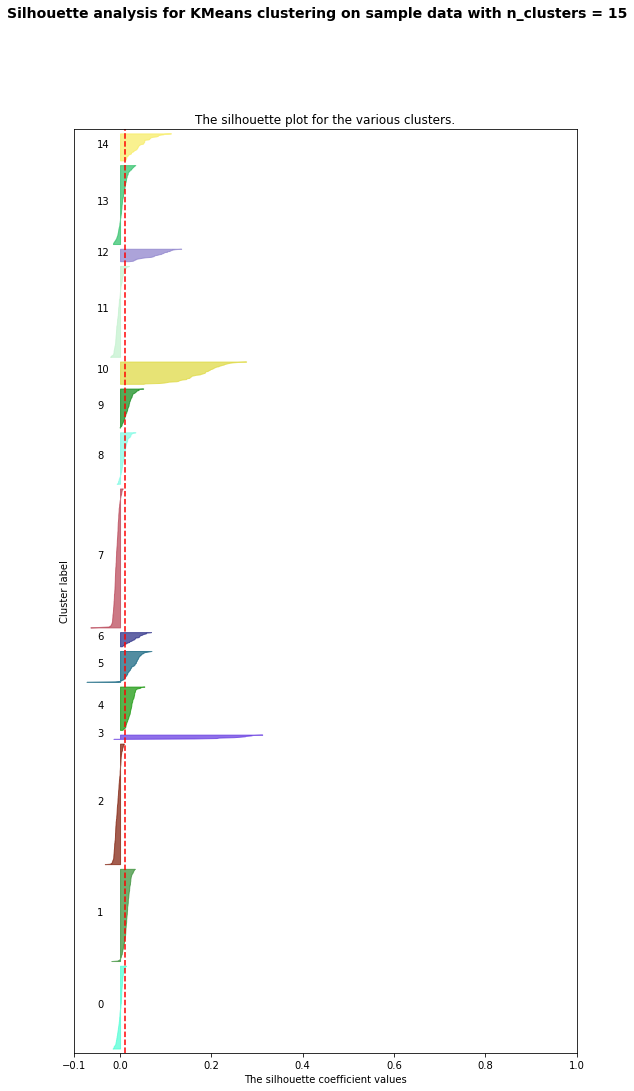

For n_clusters = 20 The average silhouette_score is : 0.018658760315539445


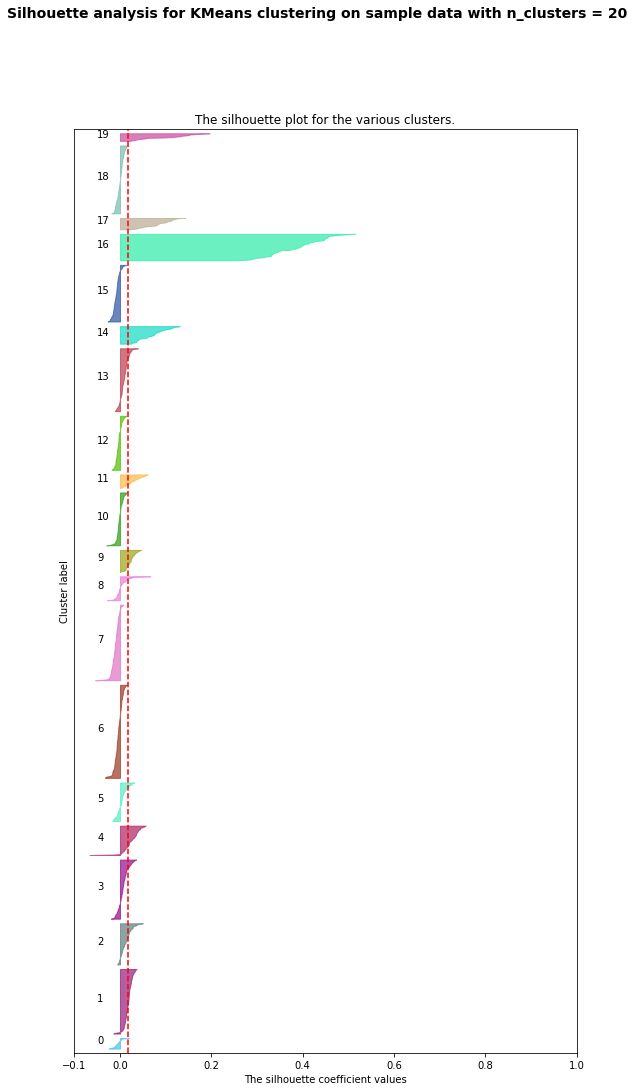

For n_clusters = 25 The average silhouette_score is : 0.019758484764803196


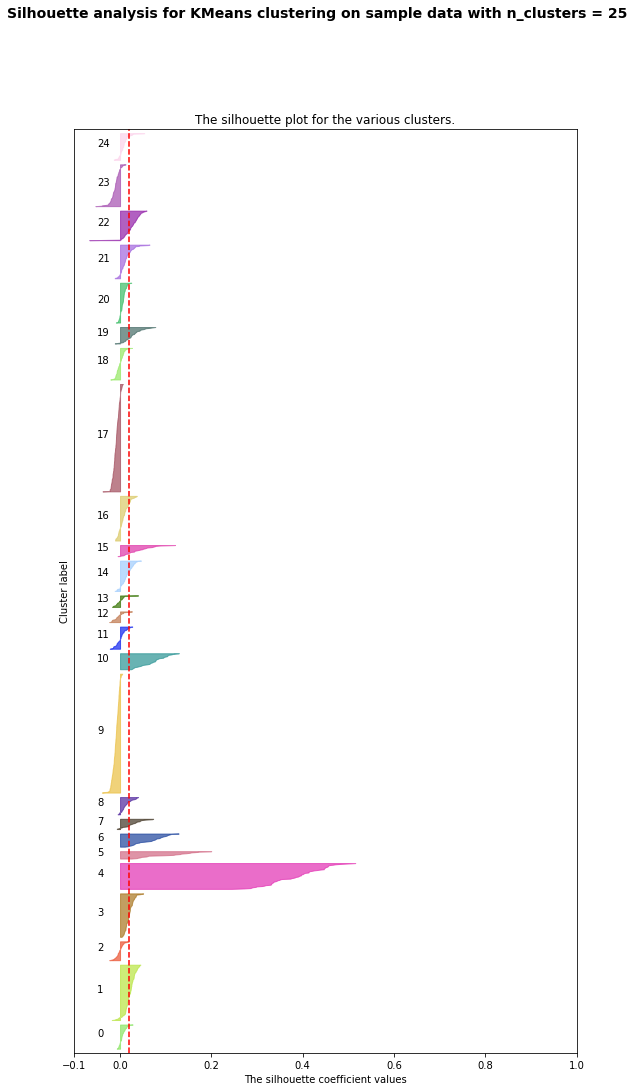

For n_clusters = 50 The average silhouette_score is : 0.01918841475532782


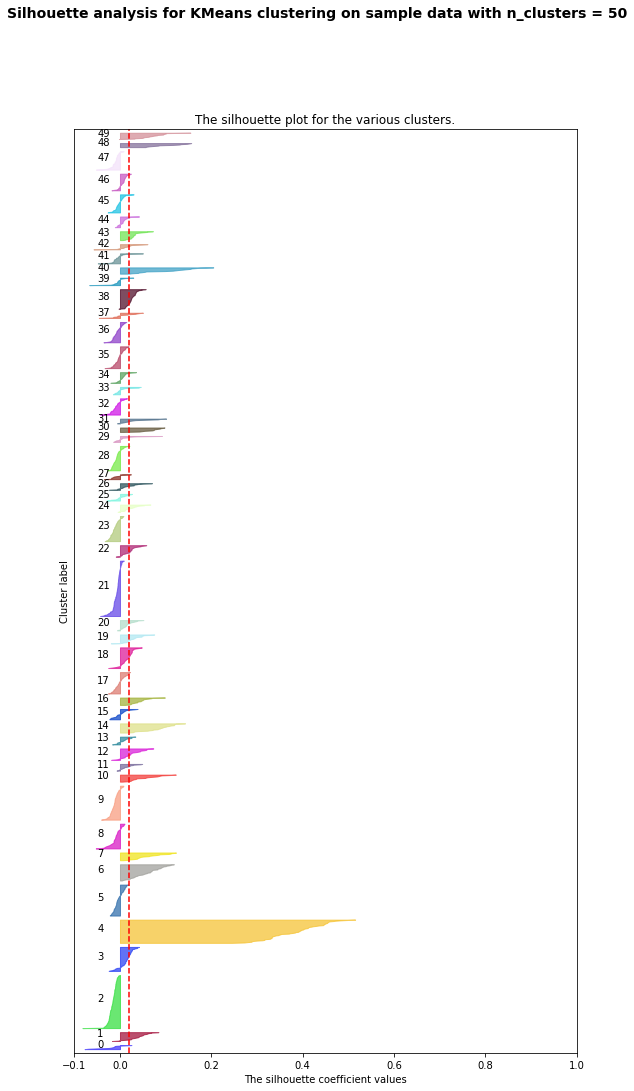

In [84]:
# modified from: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import random

X = tfidf_matrix.todense();

for n_clusters in range_n_clusters:
    # Create a subplot
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(9, 17)

    # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        # select a random color for this cluster
        r = lambda: random.randint(0,255)
        color = '#%02X%02X%02X' % (r(),r(),r())
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

In [20]:
from sklearn.externals import joblib

joblib.dump(km,  'doc_cluster.pkl')
km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [22]:
#import pandas as pd

campaigns = { 'title': titles, 'rank': ranks, 'story': stories, 'cluster': clusters, 'state': states }
exportData = { 'title': titles, 'url': urls, 'story': stories, 'cluster': clusters, 'donors': donors, 'shares': shares, 'length': lengths, 'raised': amounts, 'goal':goals, 'engagement': engagementRates, 'success': successRates, 'city': cities, 'state': states }


frame = pd.DataFrame(exportData, index = None , columns = ['title', 'url', 'cluster', 'city', 'state', 'story', 'raised', 'goal', 'engagement', 'success', 'donors', 'shares', 'length'])
# print(frame)
# frame.describe()
print(frame.head())




                                       title  \
0         Deb and Tom Carie Heart Transplant   
1  Byron&#x2019;s brain tumor trial air fare   
2                      A new smile for Conor   
3                              Jordan family   
4                Healing to Cherie Giambalvo   

                                  url  cluster       city state  \
0   https://www.gofundme.com/Debcarie        7     JASPER    IN   
1  https://www.gofundme.com/byronking        1  MELBOURNE    FL   
2      https://www.gofundme.com/w2x34        2  WOODSTOCK    GA   
3     https://www.gofundme.com/162w9c        6   PARADISE    CA   
4     https://www.gofundme.com/17n1i8        3      CHICO    CA   

                                               story  raised     goal  \
0  Ded Carie’s husband  Tom  has end stage heart ...  1575.0  10000.0   
1  Please help me fund monthly air travel for a l...  8310.0  20000.0   
2  My son Conor has recently been experiencing so...   350.0   2100.0   
3  My cousin Daw

In [296]:
##remove outliers before export
# Remove rows for which columns 'goal' or 'success' are outside the 99th percentile
# dfAll = dfObj[((dfObj['goal'] < 600) | (dfObj['goal'] > 175000)) | ((dfObj['success'] < 2) | (dfObj['success'] > 262)) ].index
# dfAll = dfObj[(dfObj['raised'] > 47376) ].index
# Delete these row indexes from dataFrame
# dfObj.drop(dfAll, inplace=True)

# print(dfObj.describe())
# dfObj.plot()
# df[((df.one > 0) | (df.two > 0) | (df.three > 0)) & (df.four < 1)]
cleanFrame = frame[((frame['goal'] < 600) | (frame['goal'] > 175000)) | ((frame['success'] < 2) | (frame['success'] > 262)) ].index
# dfAll = dfObj[(dfObj['raised'] > 47376) ].index
# Delete these row indexes from dataFrame
frame.drop(cleanFrame, inplace=True)

print(frame.describe())
# frame.plot()



           cluster         raised           goal   engagement      success  \
count  1906.000000    1906.000000    1906.000000  1906.000000  1906.000000   
mean      4.746590    5349.031480   15799.098111    14.631165    42.475866   
std       3.280948    9957.539956   21295.524229     8.993836    36.882557   
min       0.000000      75.000000     600.000000     0.000000     2.000000   
25%       1.000000     970.000000    5000.000000     8.000000    13.000000   
50%       6.000000    2205.000000   10000.000000    12.000000    31.000000   
75%       8.000000    5482.750000   20000.000000    19.000000    65.750000   
max       9.000000  156836.000000  175000.000000    50.000000   262.000000   

            donors        shares      length  
count  1906.000000   1906.000000  1906.00000  
mean     54.240818    323.460651     6.24554  
std      82.949368    679.679087     1.22637  
min       1.000000      2.000000     1.00000  
25%      13.000000     80.000000     6.00000  
50%      27.000

In [308]:

##export data
#frame['cluster'].value_counts()

# cluster_count = pd.DataFrame(campaigns, columns = ['cluster', 'state', 'rank'])
# #print(cluster_count)

# clusterData = pd.DataFrame(frame).groupby('cluster')
# print df.groupby('idx').apply(lambda x: x.to_json(orient='records'))
# clusterData = frame.groupby( [ 'cluster'] ).count()
# print(clusterData)

#print(clusterData)
####clusterData.to_json('cluster_count.json', orient='records')
export_csv = frame.to_csv ('test-med-15.csv', index = None, float_format='%.0f', header=True)


In [24]:
##get averages and min-max for all clusters
# grouped = frame['donors'].groupby(frame['cluster'])
grouped= frame.groupby(frame['cluster']).describe()
# grouped.describe()

# temp = data.groupby('name')['prop'].describe()
# temp.to_csv('out.csv')
# grouped.to_csv ('test-med-15-averages.csv', float_format='%.0f', header=True)
# grouped.to_csv ('test-med-15-averages.csv', float_format='%.0f')



frame['cluster'].value_counts()
# 

1    489
3    390
2    311
4    273
5    216
6     75
7     74
8     66
0     64
9     37
Name: cluster, dtype: int64

In [317]:
from __future__ import print_function
# print(frame.loc[1])
print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0], end=',')
        print(len(vocab_frame.loc[terms[ind].split(' ')].values))

    print()
    print()
#     print("Cluster %d titles:" % i, end='')
    
#     for title in frame.loc[i]['title'].values.tolist():
#         print(' %s,' % title, end='')
    print()
    print()

Top terms per cluster:

Cluster 0 words: get,1674
 help,4386
 go,1621
 time,2143
 work,2021
 day,1235
 know,1501
 back,1112
 us,1040
 weeks,1097




Cluster 1 words: cancer,1557
 treatment,1393
 help,4386
 breast,247
 diagnosed,748
 breast,1804
 fighting,611
 family,2524
 stage,322
 chemotherapy,345




Cluster 2 words: fire,163
 home,1055
 house,372
 lost,358
 family,2524
 help,4386
 flooded,80
 everything,410
 rebuild,59
 clothes,71




Cluster 3 words: de,1033
 que,445
 la,423
 en,356
 el,308
 para,241
 un,238
 su,189
 por,184
 unas,152




Cluster 4 words: kidney,286
 transplant,267
 dialysis,69
 kidney,553
 kidney,361
 donor,69
 help,4386
 failure,75
 family,2524
 work,2021




Cluster 5 words: car,358
 accident,265
 help,4386
 broken,143
 injury,225
 recovery,492
 work,2021
 car,623
 family,2524
 road,268




Cluster 6 words: surgery,1638
 help,4386
 years,1852
 work,2021
 tumor,464
 eyes,185
 get,1674
 insurance,737
 cover,576
 remove,382




Cluster 7 words: years,1852
 help,43

In [111]:
# ##test for count of each km centroid term per cluster (not total in corpus)
# ##
# from __future__ import print_function
# # print(frame.loc[1])
# print("Top terms per cluster:")
# print()
# order_centroids = km.cluster_centers_.argsort()[:, ::-1]
# for i in range(num_clusters):
#     print("Cluster %d words:" % i, end='')
#     for ind in order_centroids[i, :10]:
# #         print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0], end=',')
#         print(len(vocab_frame.ix[terms[ind]]))

#     print()
#     print()
#     print("Cluster %d titles:" % i, end='')
    
# #     for title in frame.loc[i]['title'].values.tolist():
# #         print(' %s,' % title, end='')
#     print()
#     print()

In [86]:
#This is purely to help export tables to html and to correct for my 0 start rank (so that Godfather is 1, not 0)
frame['Rank'] = frame['rank'] + 1
frame['Title'] = frame['title']

KeyError: 'rank'

In [75]:
#export tables to HTML
print(frame[['Rank', 'Title']].loc[frame['cluster'] == 2].to_html(index=False))

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Rank</th>
      <th>Title</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>3</td>
      <td>We need a Christmas Miracle</td>
    </tr>
    <tr>
      <td>7</td>
      <td>Reinstate Grandparents&amp;apos; Health Insurance</td>
    </tr>
    <tr>
      <td>30</td>
      <td>A cry for help</td>
    </tr>
    <tr>
      <td>34</td>
      <td>Sandy&amp;apos;s Fund</td>
    </tr>
    <tr>
      <td>39</td>
      <td>Hoefling Family Medical Emergency</td>
    </tr>
    <tr>
      <td>43</td>
      <td>Help for Charlie and Jill Galuten</td>
    </tr>
    <tr>
      <td>45</td>
      <td>Hand in Hand with Howard</td>
    </tr>
    <tr>
      <td>52</td>
      <td>Move Mountains For Danielle Mumm</td>
    </tr>
    <tr>
      <td>54</td>
      <td>Help Grant Austin &amp;amp; Family</td>
    </tr>
    <tr>
      <td>56</td>
      <td>Medical Support For Tahia&amp;apos;s Recovery</td>
    </tr>
    <

# Multidimensional scaling

In [87]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=5)

#mds = MDS(n_components=2, metric=True, random_state=1, dissimilarity='precomputed')


pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [136]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

## Visualizing document clusters

In [88]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e' }

#set up cluster names using a dict
cluster_names = {0: 'cancer, treatments, chemotherapy, radiation, family', 
                 1: 'family, support, loving, time, friends', 
                 2: 'medical, hospital, family, heart, care', 
                 3: 'surgery, need, would, cancer, work', 
                 4: 'years, work, getting, time, months'
                }

In [133]:
# import matplotlib.pyplot as plt
%matplotlib inline

In [94]:


# #print data with cluster to json
# #campaigns, index = [clusters] , columns = ['rank', 'title', 'cluster', 'state'])
# #campaigns = { 'title': titles, 'rank': ranks, 'story': stories, 'cluster': clusters, 'state': states }

# # column headers
# # name,economy (mpg),cylinders,displacement (cc),power (hp),weight (lb),0-60 mph (s),year
# # category,createdDate,storyTitle,amountRaised,goal,donors,campaignLength,likes,shares,city,state,story


# #frame = pd.DataFrame(campaigns, index = [clusters] , columns = ['rank', 'title', 'cluster', 'state'])
# # cData.reset_index(inplace=True)
# # print(cD)

# # #Data = {'Product': ['Desktop Computer','Tablet','iPhone','Laptop'],
# #         'Price': [700,250,800,1200]
# #         }

# #export to csv
# #newData = pd.DataFrame.to_csv(path_or_buf=None, sep=', ', na_rep='', float_format=None, columns =['title','cluster', 'state'], header=True) 

# # categories = data.category.tolist()
# # titles = data.storyTitle.tolist()
# # states = data.state.tolist()
# # stories = data.story.tolist()
# # dates = data.createdDate.tolist()
# # amounts = data.amountRaised.tolist()
# # goals = data.goal.tolist()
# # donors = data.donors.tolist()
# # lengths = data.campaignLength.tolist()
# # likes = data.likes.tolist()
# # shares = data.shares.tolist()
# # cities = data.city.tolist()

# cData = { 'title': titles, 'cluster': clusters, 'date': dates, 'raised': amounts, 'goal': goals, 'donors': donors, 'length': lengths, 'likes': likes, 'shares': shares, 'state': states }

# # df1.Value1 = df1.Value1.str.replace(',', '.').astype(float)

# cData['raised'] = newData.raised.str.replace('$', '').str.replace(',','').astype('int')
# cData['goal'] = newData.goal.str.replace('$', '').str.replace(',','').astype('int')



##set dataframe with data, and columns to include for export
newData = pd.DataFrame(exportData, columns = ['cluster', 'raised', 'goal', 'engagement', 'success', 'donors', 'shares', 'length', 'city', 'state', 'title', 'url', 'story'])

##remove outliers from dataFrame
##https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
# df = pd.DataFrame(np.random.randn(100, 3))

# from scipy import stats

#get dataframe summary
normalize.describe()
# newData = pd.DataFrame(cData, columns =['cluster', 'raised', 'goal', 'donors', 'length', 'shares'])
# # newData = pd.DataFrame(cData, columns =['cluster', 'donors', 'length', 'likes', 'shares'])


# #cData.pivot_table(index='state', columns=['rank', 'title', 'cluster', 'state']).swaplevel(axis=1).sort_index(1)
# print(newData)
###
##export to json
# newData.to_json('cleanHealthFullCols.json', orient='records')
###
##export to csv
########export_csv = newData.to_csv ('gfmCleanHealthFullCols.csv', index = None, float_format='%.0f', header=True)

##float format to determine places after decimal
# #float_format='%.2f'

TypeError: unsupported operand type(s) for /: 'str' and 'int'

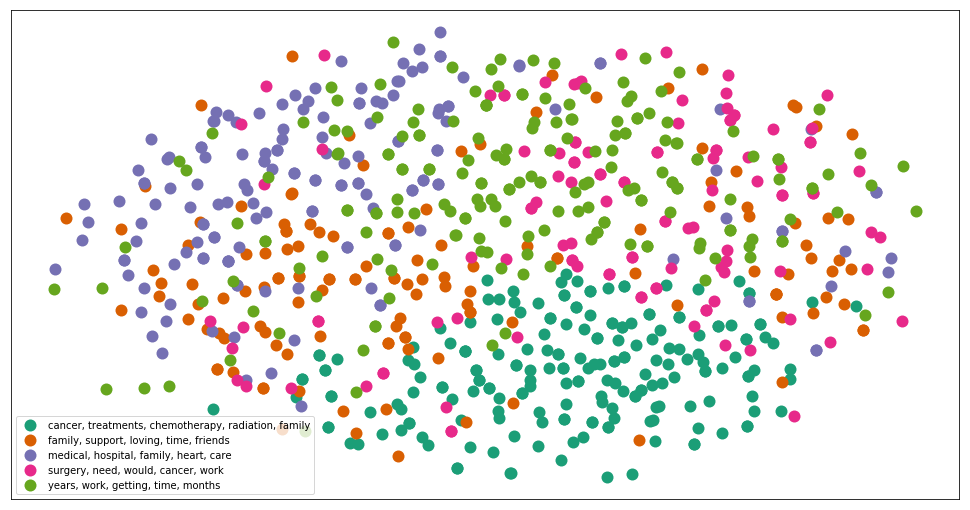

In [140]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top= False,         # ticks along the top edge are off
        labelbottom=False)
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelleft=False)
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
# for i in range(len(df)):
#     ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [120]:
plt.close()

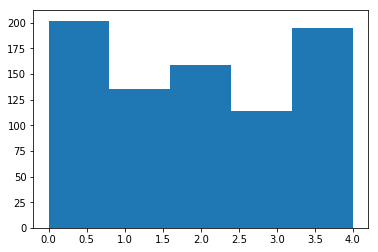

In [121]:
plt.hist(clusters, bins=5)
plt.show()

The clustering plot looks great, but it pains my eyes to see overlapping labels. Having some experience with [D3.js](http://d3js.org/) I knew one solution would be to use a browser based/javascript interactive. Fortunately, I recently stumbled upon [mpld3](https://mpld3.github.io/) a matplotlib wrapper for D3. Mpld3 basically let's you use matplotlib syntax to create web interactives. It has a really easy, high-level API for adding tooltips on mouse hover, which is what I am interested in.

It also has some nice functionality for zooming and panning. The below javascript snippet basicaly defines a custom location for where the zoom/pan toggle resides. Don't worry about it too much and you actually don't need to use it, but it helped for formatting purposes when exporting to the web later. The only thing you might want to change is the x and y attr for the position of the toolbar.

In [122]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [123]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, label=cluster_names[name], mec='none', color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)

# Hierarchical document clustering

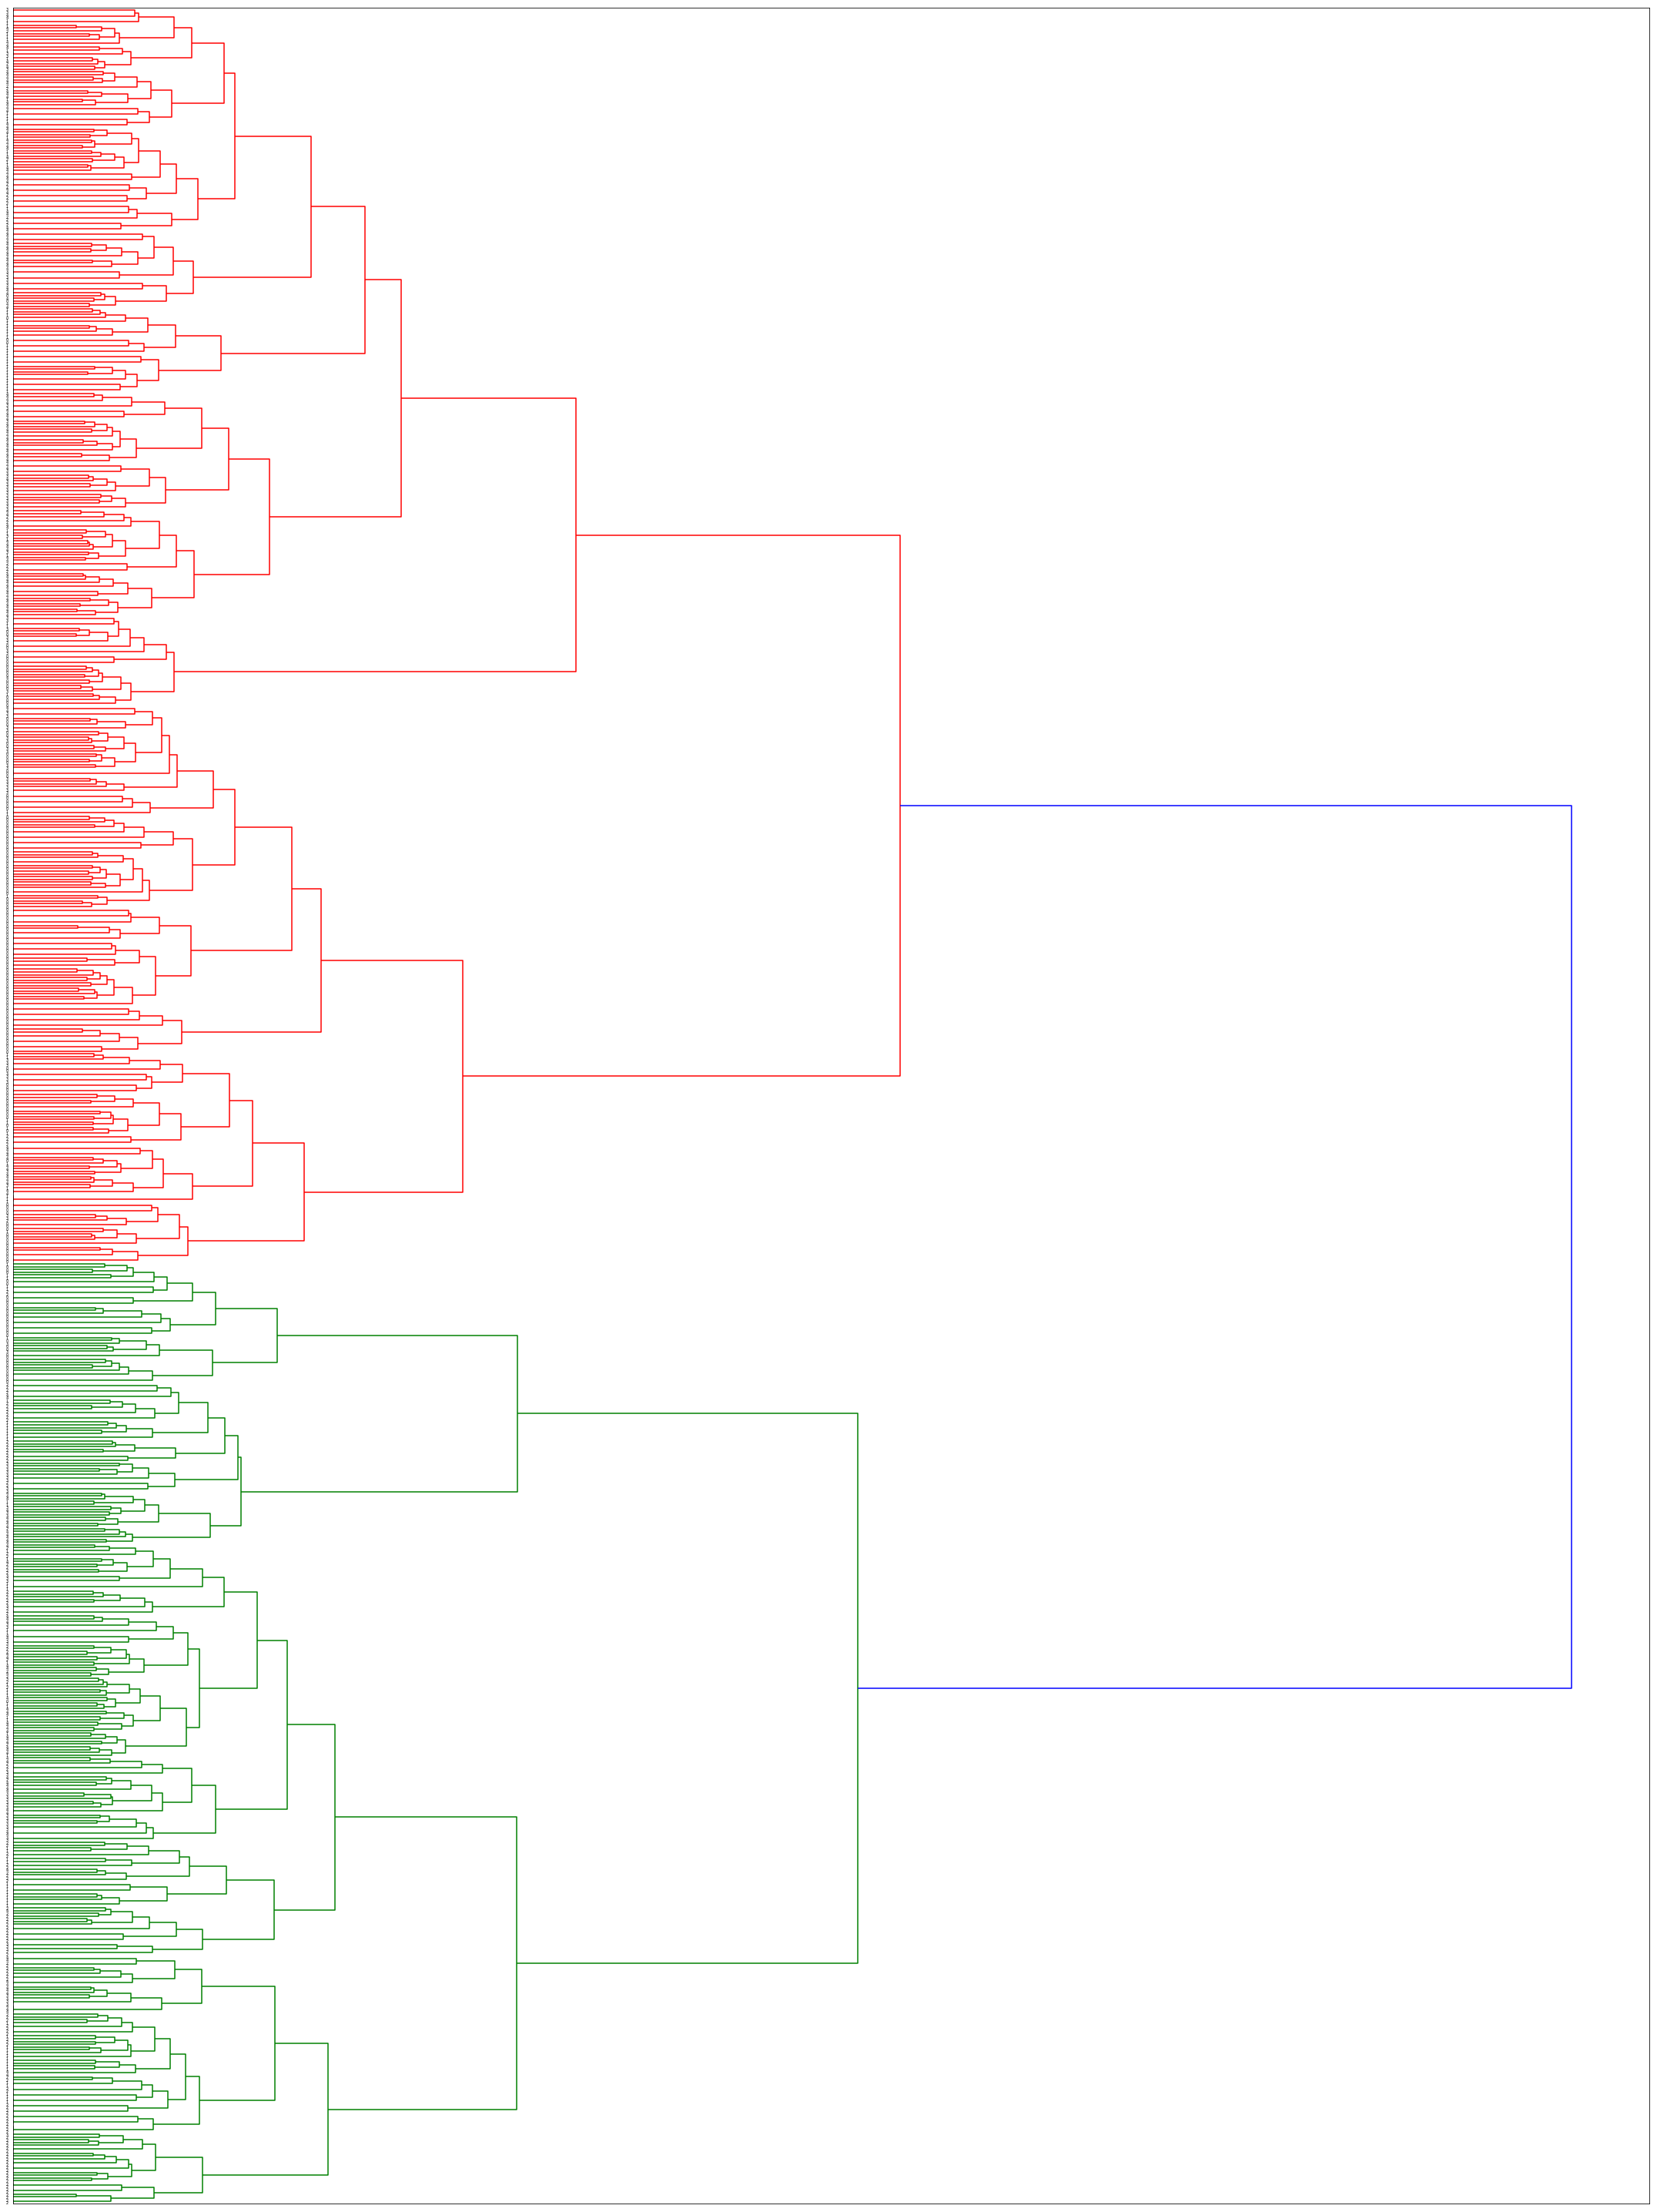

In [113]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(30, 40)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=clusters);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom= False,      # ticks along the bottom edge are off
    top= False,         # ticks along the top edge are off
    labelbottom= False)

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [556]:
plt.close()

# Latent Dirichlet Allocation

In [22]:
#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [23]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [25]:
#LDA example
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

#Latent Dirichlet Allocation implementation with Gensim
import gensim

from gensim import corpora, models, similarities 
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

#remove proper names
# preprocess = [strip_proppers(doc) for doc in stories]

%time tokenized_text = [tokenize_and_stem(text) for text in stories]

%time texts = [[word for word in text if word not in stop_words] for text in tokenized_text]

#troubleshoot: https://stackoverflow.com/questions/46986560/wordlistcorpusreader-is-not-iterable
# from nltk.corpus import stopwords
# stop_words = set(stopwords.words("english"))
# for w in tokenized_sent:
#     if w not in stop_words:
#         pass # Do something.

CPU times: user 7.59 s, sys: 70.7 ms, total: 7.66 s
Wall time: 7.83 s
CPU times: user 94.7 ms, sys: 2.09 ms, total: 96.8 ms
Wall time: 96.3 ms


In [28]:
#print(len([word for word in texts[0] if word not in stopwords]))
print(len(texts))

805


In [29]:
dictionary = corpora.Dictionary(texts)
print(dictionary[101])

two


In [30]:
dictionary.filter_extremes(no_below=0.2, no_above=0.8)

In [31]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
len(corpus)


In [ ]:
%time lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=20, chunksize=10000, passes=100)

In [182]:
print(lda[corpus[0]])

[(1, 0.53498954), (3, 0.11823306), (4, 0.25349927), (14, 0.087757)]


In [ ]:
topics = lda.print_topics(5, num_words=10)

In [35]:
topics_matrix = lda.show_topics(formatted=False, num_words=10)

In [185]:
topics_matrix = np.array(topics_matrix)

In [186]:
topics_matrix.shape

(10, 2)

In [187]:
topic_words = topics_matrix[:,1]

In [188]:
for i in topic_words:
    print([str(word) for word in i])
    print()

["('year', 0.008368138)", "('work', 0.008055026)", "('cancer', 0.0077703865)", "('time', 0.0077167586)", "('famili', 0.0075083757)", "('life', 0.0072141117)", "('need', 0.0067531173)", "('get', 0.006614619)", "('go', 0.0065971217)", "('know', 0.0063440176)", "('medic', 0.006065002)", "('would', 0.0058609485)", "('day', 0.005636921)", "('treatment', 0.0052747796)", "('month', 0.004982669)", "('hospit', 0.0046436773)", "('make', 0.004563514)", "('one', 0.004509762)", "('love', 0.0045081154)", "('ani', 0.004381791)"]

["('medic', 0.012165575)", "('get', 0.0076854)", "('know', 0.0068464926)", "('time', 0.00676547)", "('work', 0.006597937)", "('week', 0.006095929)", "('famili', 0.0059999996)", "('cancer', 0.0057941284)", "('went', 0.0056108763)", "('need', 0.005548405)", "('friend', 0.005386818)", "('back', 0.0053321267)", "('bill', 0.005321901)", "('diagnos', 0.0053097135)", "('scan', 0.00528378)", "('doctor', 0.004838666)", "('treatment', 0.004780845)", "('one', 0.00467899)", "('debt', 0.